# DeepGaze II and ICF

This notebook demonstrates how to load and use the DeepGaze II and ICF models.
It needs
to be run using python3 and an up to date tensor flow installation (I use
tensorflow 1.1, but tensorflow 1.0 might work, too). Using a GPU will
considerably speed up computation

In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns
sns.set_style('white')
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
import tensorflow as tf

In [ ]:
# our example image for which we will calculate DeepGaze predictions

from scipy.misc import face
img = cv2.imread('/home/xavi_oliva/Downloads/Lenna_(test_image).png',0)

plt.imshow(img)
plt.axis('off');

The model expects all input as 4d tensors of shape `BHWC` (i.e. batch-height-
width-channel). It takes two inputs:
A batch of images and a batch of centerbias log densities. Here we create the
input data to process one image with a uniform center bias.

In [5]:
image_data = img[np.newaxis, :, :, :]  # BHWC, three channels (RGB)
centerbias_data = np.zeros((1, img.shape[0], img.shape[1], 1))  # BHWC, 1 channel (log density)

Now we import the deep gaze model from the tensorflow meta-graph file

In [6]:
tf.reset_default_graph()

In [7]:
check_point = 'DeepGazeII.ckpt'  # DeepGaze II
#check_point = 'ICF.ckpt'  # ICF
new_saver = tf.train.import_meta_graph('{}.meta'.format(check_point))

input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

And finally we create a tensorflow session, restore the model parameters from
the checkpoint and compute the log density prediction for out input data:

In [8]:
with tf.Session() as sess:
    
    new_saver.restore(sess, check_point)
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

INFO:tensorflow:Restoring parameters from DeepGazeII.ckpt


The log density predictions again are of shape `BHWC`. Since the log-densities
are just 2d, `C=1`. And since we processed only one image, `B=1`:

In [8]:
log_density_prediction = np.load('/home/xavi_oliva/Downloads/9d3217f6-fc86-45e1-99d5-da05d5f63126.npy')
saliency = np.exp(log_density_prediction)
print(log_density_prediction.shape)

import scipy.misc
scipy.misc.imsave('leena_saliency_map.png', saliency)

(512, 512)


/home/xavi_oliva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Finally, we can visualize the model prediction. This is how the log density
looks like:

NameError: name 'img' is not defined

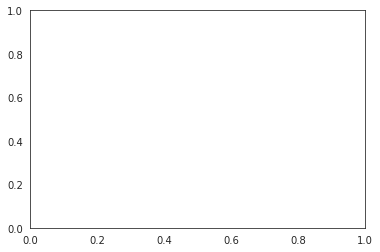

In [4]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');

And this is how the corresponding density looks like

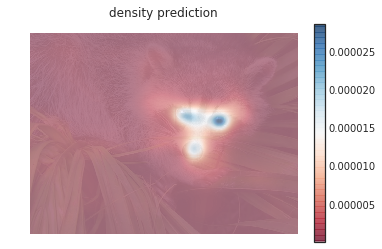

In [11]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow(np.exp(log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('density prediction')
plt.axis('off');

For converting these predictions into saliency maps for the different saliency metrics (AUC, sAUC, CC, SIM, ...), have a look at *Kümmerer et. al: Saliency Benchmarking: Separating Moldels, Maps and Metrics.* [ArXiV 1704.08615](https://arxiv.org/abs/1704.08615)